# MUC16 trans effect histograms for interacting proteins


This notebook analyzes the trans effect of ATRX mutation for all proteins.

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import cptac
import cptac.utils as al

In [2]:
brain = cptac.Gbm()

### Specify Gene

In [3]:
gene = "MUC16"

# Get Interacting Proteins

In [4]:
#Use get interacting proteins method to generate list of interacting proteins
interacting_proteins = al.get_interacting_proteins(gene)
interacting_proteins.remove('MUC16')
#Show interacting protein list
print("Interacting Proteins:\n")
for interacting_protein in interacting_proteins:
    print(interacting_protein)

Interacting Proteins:

MUC17
ST6GAL1
ST6GALNAC2
ST3GAL3
C1GALT1C1
ST6GALNAC3
ST6GALNAC4
MUC21
MUC3A
ST3GAL2
MSLN
C1GALT1
MUC6
MUC7
MUC20
MUC15
MUC4
ST3GAL1
ST3GAL4
GALNT4
MUC5B
MUC12
MUC1
MUC13
MUC5AC
LGALS1
IGBP1
UBC
RAD21
CEP170P1
MCM2
NANOG
POU5F1
EGFR
TRIM25
KIAA1429


# Transcriptomics: Interacting Proteins

In [5]:
transcrpt = "transcriptomics"

try:
    print("\nGene: ", gene)

    #Create dataframe in order to do comparisons with wrap_ttest
    transcrpt_df = brain.join_omics_to_mutations(mutations_genes=[gene], 
                                                 omics_genes= interacting_proteins, 
                                                 omics_df_name=transcrpt)

    transcrpt_df = brain.reduce_multiindex(transcrpt_df, flatten=True)
    transcrpt_df = transcrpt_df[transcrpt_df.Sample_Status == 'Tumor'] # drop Normal samples
    transcrpt_df = transcrpt_df.dropna(axis=1, how='all') # drop columns with all NaN data
    
    #Create the binary valued column needed to do the comparison
    for ind, row in transcrpt_df.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            transcrpt_df.at[ind,'Label'] = 'Mutated'
        else:
            transcrpt_df.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    transcrpt_df = transcrpt_df.drop(gene+"_Mutation",axis=1)
    transcrpt_df = transcrpt_df.drop(gene+"_Location",axis=1)
    transcrpt_df = transcrpt_df.drop(gene+"_Mutation_Status", axis=1)
    transcrpt_df = transcrpt_df.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    t_col_list = list(transcrpt_df.columns)
    t_col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    transcrpt_all_comparisons = al.wrap_ttest(transcrpt_df, 'Label', t_col_list, return_all=True)

    t_num_comparisons = len(t_col_list)
    print("Number of comparisons:", t_num_comparisons)
    t_bonferroni_cutoff = .05 / t_num_comparisons
    print("Bonferroni cutoff = ", t_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", np.log10(t_bonferroni_cutoff))

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  MUC16
Doing t-test comparisons

1 significant comparisons!
Number of comparisons: 36
Bonferroni cutoff =  0.001388888888888889
Logged Bonferroni cutoff =  -2.8573324964312685


Transcriptomics: Print Significant Comparisons

In [6]:
transcrpt_real_pvals = transcrpt_all_comparisons.dropna(axis=0)
transcrpt_sig_comparisons = transcrpt_real_pvals.loc[transcrpt_real_pvals['P_Value'] <= t_bonferroni_cutoff]
print("Number of significant comparisons for Transcriptomics: ", len(transcrpt_sig_comparisons), '\n')

if len(transcrpt_sig_comparisons) > 0:
    print(transcrpt_sig_comparisons)

Number of significant comparisons for Transcriptomics:  1 

                                     Comparison   P_Value
0  ST6GALNAC2_transcriptomics_ENSG00000070731.8  0.000406


Transcriptomics: Histogram for all proteins

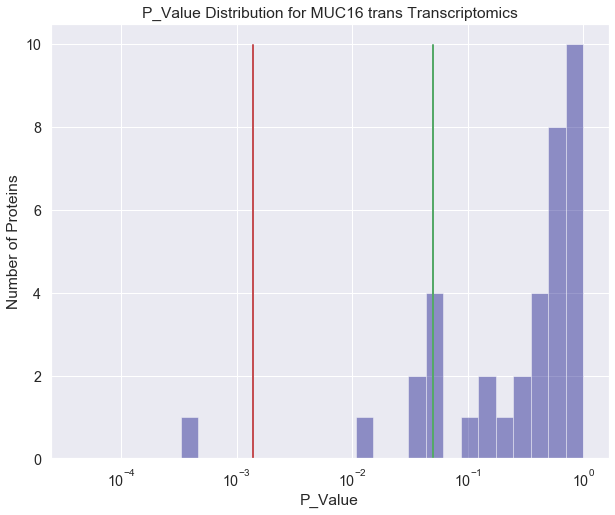

In [7]:
# Create series of p-values for Histogram
transcrpt_pval_series = transcrpt_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
t_log_min, t_log_max = np.log10(transcrpt_pval_series.min()), np.log10(transcrpt_pval_series.max())
t_bins = np.logspace(t_log_min - 1, t_log_max, 30) # change bin number here
histogram = sns.distplot(transcrpt_pval_series, bins = t_bins, kde=False, color='navy') 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-5,10e-1]) # change x-axis range
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red

plt.axvline(t_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Transcriptomics zoomed in

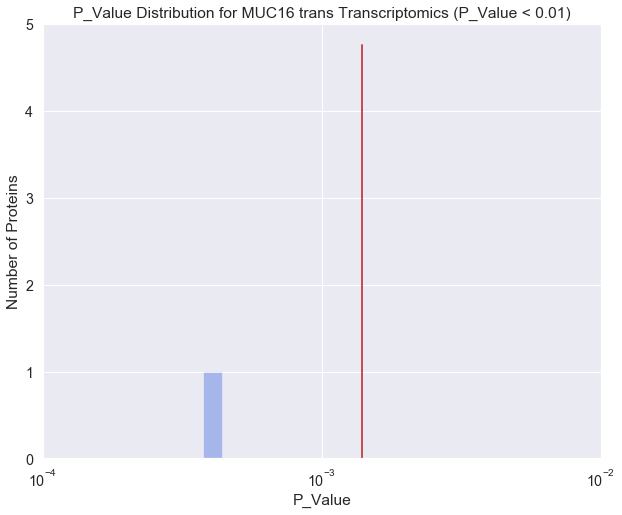

In [8]:
# Select p-values within range 0 - end_value 
t_end_value = 0.01
transcrpt_zoomed = transcrpt_pval_series.loc[transcrpt_pval_series <= t_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
t_zoomed_log_min, t_zoomed_log_max = np.log10(transcrpt_zoomed.min()),np.log10(transcrpt_zoomed.max())
t_zoomed_bins = np.logspace(t_zoomed_log_min - 1, t_zoomed_log_max +1, 30) # change this number for more or less bins
histogram = sns.distplot(transcrpt_zoomed, bins=t_zoomed_bins, kde=False, color='royalblue')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics (P_Value < " + str(t_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-5,10e-3]) # change x-axis range
plt.ylim([0.0,5]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(t_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

# Proteomics: Interacting Proteins

In [9]:
prot = "proteomics"

try:
    print("\nGene: ", gene)

    #Create dataframe in order to do comparisons with wrap_ttest
    protdf = brain.join_omics_to_mutations(mutations_genes=[gene],
                                           omics_genes=interacting_proteins,
                                           omics_df_name=prot)
    protdf = brain.reduce_multiindex(protdf, flatten=True)
    protdf = protdf[protdf.Sample_Status == 'Tumor'] # drop Normal samples
    protdf = protdf.dropna(axis=1, how='all') # drop columns with all NaN data
    
    #Create the binary valued column needed to do the comparison
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    prot_col_list = list(protdf.columns)
    
    prot_col_list.remove('Label')
    

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    prot_all_comparisons = al.wrap_ttest(protdf, 'Label', prot_col_list, return_all=True)

    prot_num_comparisons = len(prot_col_list)
    print("Number of comparisons:", prot_num_comparisons)
    prot_bonferroni_cutoff = .05 / prot_num_comparisons
    print("Bonferroni cutoff = ", prot_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", np.log10(prot_bonferroni_cutoff))

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  MUC16
Doing t-test comparisons

No significant comparisons.
Number of comparisons: 13
Bonferroni cutoff =  0.0038461538461538464
Logged Bonferroni cutoff =  -2.4149733479708178


Print Significant Comparisons

In [10]:
prot_all_comparisons = prot_all_comparisons.dropna(axis=0)
prot_sig_comparisons = prot_all_comparisons.loc[prot_all_comparisons['P_Value'] <= prot_bonferroni_cutoff]
print("Number of significant Proteomics comparisons: ", len(prot_sig_comparisons), '\n')

if len(prot_sig_comparisons) > 0:
    print(prot_sig_comparisons)

Number of significant Proteomics comparisons:  0 



Proteomics Histograms 

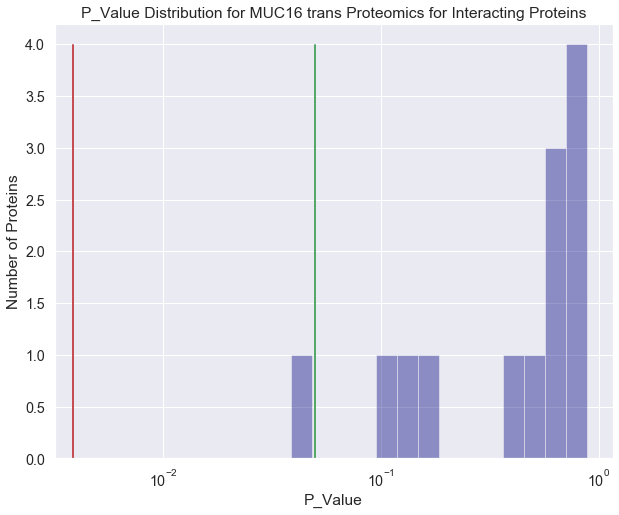

In [11]:
# Create series of p-values for Histogram
prot_pval_series = prot_all_comparisons['P_Value']

# Create log scale for the x-axis
plt.xscale('log')
prot_log_min, prot_log_max = np.log10(prot_pval_series.min()), np.log10(prot_pval_series.max())
prot_bins = np.logspace(prot_log_min -1, prot_log_max, 25) # change bin number here
histogram = sns.distplot(prot_pval_series, bins = prot_bins, kde=False, color='navy') 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics for Interacting Proteins")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-5,10e-1]) # change x-axis range
#plt.ylim([0, 5]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(prot_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Proteomics zoomed in 

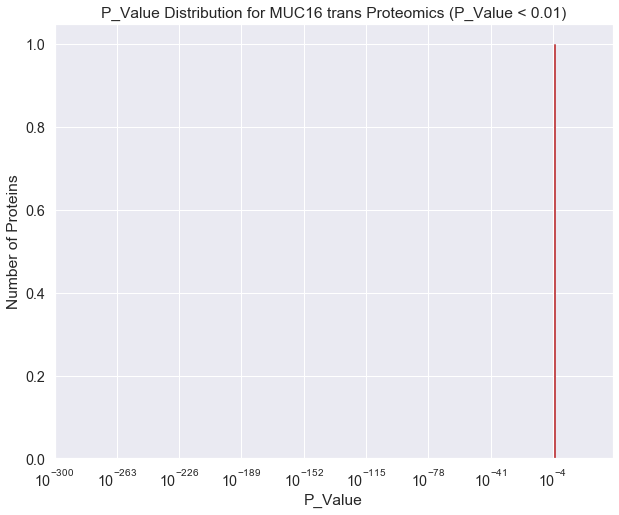

In [12]:
# Select p-values within range 0 - end_value 
prot_end_value = 0.01
prot_zoomed = prot_pval_series.loc[prot_pval_series <= prot_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
zoomed_log_min, zoomed_log_max = np.log10(prot_zoomed.min()),np.log10(prot_zoomed.max())
prot_bins_zoomed = np.logspace(zoomed_log_min - 1, zoomed_log_max, 10) # change this number for more or less bins
histogram = sns.distplot(prot_zoomed, bins = prot_bins_zoomed, kde=False, color='royalblue')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics (P_Value < " + str(prot_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-5,10e-3]) # change x-axis range
#plt.ylim([0.0,20]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(prot_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

# Phosphoproteomics: Interacting Proteins

In [13]:
phos = 'phosphoproteomics'

try:
    print("\nGene: ", gene)

    # Create dataframe in order to do comparisons with wrap_ttest
    phosdf = brain.join_omics_to_mutations(mutations_genes=[gene], 
                                           omics_genes=interacting_proteins,
                                           omics_df_name=phos)
    phosdf = brain.reduce_multiindex(phosdf, flatten = True)
    phosdf = phosdf.loc[phosdf['Sample_Status'] == 'Tumor']
    phosdf = phosdf.dropna(axis=1, how='all') # drop columns with all NaN data
    
    # Create the binary valued column needed to do the comparison
    for ind, row in phosdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            phosdf.at[ind,'Label'] = 'Mutated'
        else:
            phosdf.at[ind,'Label'] = 'Wildtype'

    # Format the datafram correctly'''
    phosdf = phosdf.drop(gene+"_Mutation",axis=1)
    phosdf = phosdf.drop(gene+"_Location",axis=1)
    phosdf = phosdf.drop(gene+"_Mutation_Status", axis=1)
    phosdf = phosdf.drop("Sample_Status",axis=1)

    # Make list of columns to be compared using t-tests
    phos_col_list = list(phosdf.columns)
    phos_col_list.remove('Label')
    
    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    phos_all_comparisons = al.wrap_ttest(phosdf, 'Label', phos_col_list, return_all=True)
    
    phos_num_comparisons = len(phos_col_list)
    print("Number of comparisons:", phos_num_comparisons)
    phos_bonferroni_cutoff = .05 / phos_num_comparisons
    print("Bonferroni cutoff = ", phos_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", np.log10(phos_bonferroni_cutoff))
            
        
except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  MUC16


Doing t-test comparisons

No significant comparisons.
Number of comparisons: 113
Bonferroni cutoff =  0.00044247787610619474
Logged Bonferroni cutoff =  -3.3541084391474008


Print Significant Comparisons

In [14]:
phos_all_comparisons = phos_all_comparisons.dropna(axis=0)
phos_sig_comparisons = phos_all_comparisons.loc[phos_all_comparisons['P_Value'] <= phos_bonferroni_cutoff]
print("Number of significant Proteomics comparisons: ", len(phos_sig_comparisons),'\n')

if len(phos_sig_comparisons) > 0:
    print(phos_sig_comparisons)

Number of significant Proteomics comparisons:  0 



Phosphoproteomics Histograms

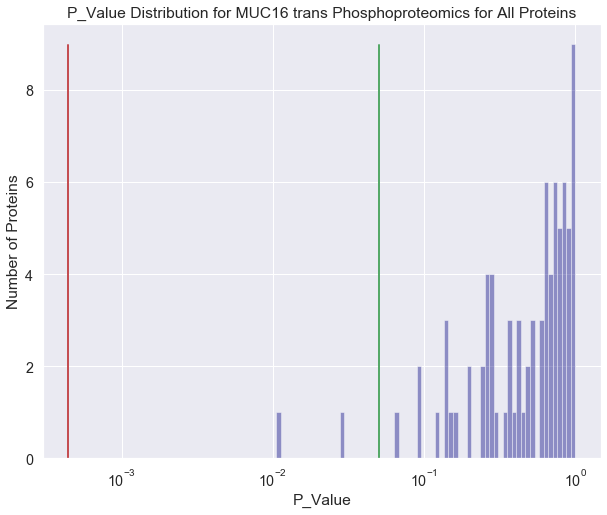

In [15]:
# Create series of p-values for Histogram
phos_pval_series = phos_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
phos_log_min, phos_log_max = np.log10(phos_pval_series.min()), np.log10(phos_pval_series.max())
phos_bins = np.logspace(phos_log_min - 1, phos_log_max, 100) # change bin number here
histogram = sns.distplot(phos_pval_series, bins = phos_bins, kde=False, color='navy') 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Phosphoproteomics for All Proteins")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-6,10e-1]) # change x-axis range
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(phos_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Phosphoproteomics zoomed in

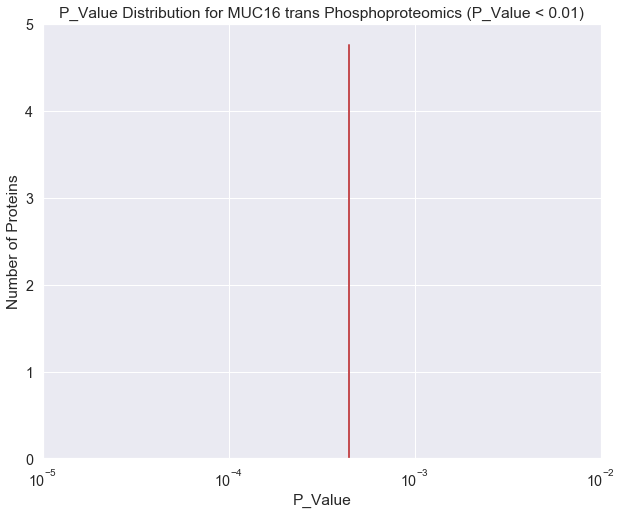

In [16]:
# Select p-values within range 0 - end_value 
phos_end_value = 0.01
phos_zoomed = phos_pval_series.loc[phos_pval_series <= phos_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
phos_zoomed_log_min, phos_zoomed_log_max = np.log10(phos_zoomed.min()),np.log10(phos_zoomed.max())
phos_bins_zoomed = np.logspace(phos_zoomed_log_min - 1, phos_zoomed_log_max, 20) # change this number for more or less bins
histogram = sns.distplot(phos_zoomed, bins = phos_bins_zoomed, kde=False, color='royalblue')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Phosphoproteomics (P_Value < " + str(phos_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-6,10e-3]) # change x-axis range
plt.ylim([0.0,5]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(phos_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()